In [2]:
import numpy as np
import plotly.express as px
import scipy.stats as sts
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import quad


def priceDemandFunc(delta_price):
    return ( 1 / ( 1 + np.exp(6-delta_price/10) ) - 0.0025 )

def calculateOptimalOrderQuantity(p,p_L,c,c_s,stdevDemand, meanDemand):
    overage_cost = p - c
    underage_cost = c + c_s - p_L
    quantile = overage_cost / ( overage_cost + underage_cost)
    optimalQuantity = sts.norm.ppf(quantile, loc=meanDemand, scale=stdevDemand)
    return optimalQuantity

def int_dist(y,dist):
    f = dist.pdf(y)
    return y * f

def calculateOptimalProfit(p,p_L,c,c_s,Q_star, meanDemand, stdevDemand):
    dist = sts.norm(loc=meanDemand,scale=stdevDemand)
    integral_value = quad(int_dist,0,Q_star,args=(dist,))[0]
    t1 = p * integral_value
    t2 = p * Q_star * dist.sf(Q_star)
    t3 = c * Q_star
    t4 = dist.cdf(Q_star)*(p_L - c_s) - integral_value*(p_L - c_s)
    return t1 + t2 - t3 + t4

# These numbers are from the main street A average demand, and can be assigned as desired.
stdevDemand = 42.255709
meanDemand = 66.527485

cost_increase = 1.25

cost = 3.85
newCost = cost * cost_increase

price = 4.64
priceLow = 0.15

shippingCost = 0.11
newShippingCost = shippingCost * cost_increase


originalOptimalOrderQuantity = calculateOptimalOrderQuantity(price,priceLow,cost,shippingCost,stdevDemand,meanDemand)
originalProfit = calculateOptimalProfit(price, priceLow, cost, shippingCost, originalOptimalOrderQuantity, meanDemand, stdevDemand)

print("Before the price increase we have Q* = {0} and profit = {1}".format(originalOptimalOrderQuantity, originalProfit))

Before the price increase we have Q* = 26.49801564725761 and profit = 7.67006597084802


Now we shall plot the changed prices

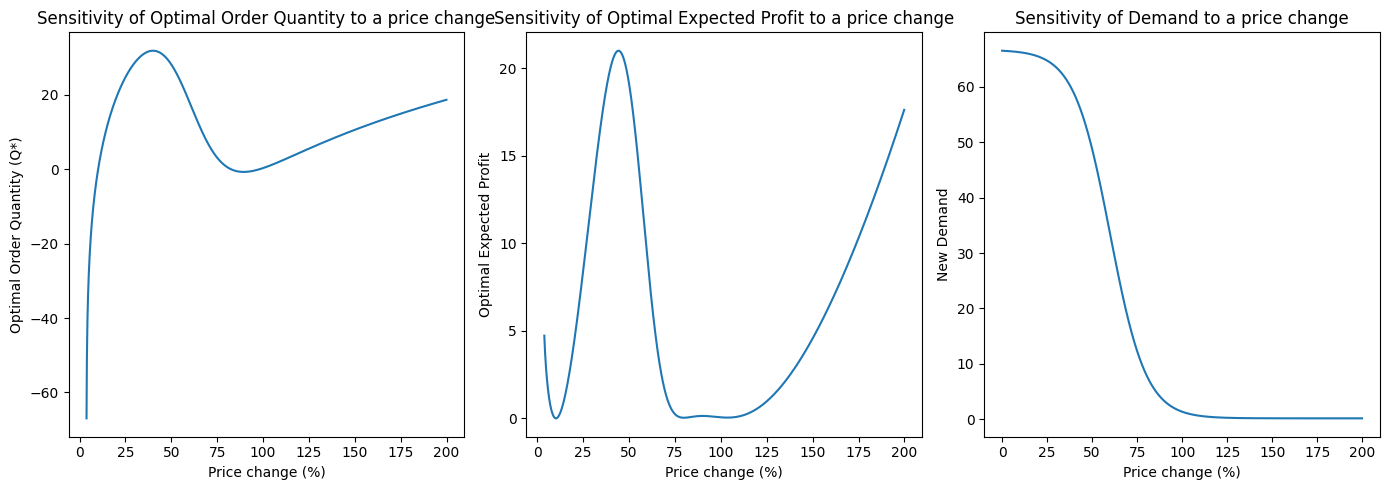

In [3]:
# Optimal order quantity vs shipping expenses
price_values_change = np.arange(0, 2, 0.001)  # Adjust the range as needed

# Lists to store the results
optimal_quantity = []
optimal_profit = []
final_demand = []

# Calculate Q* and optimal profit for each cS value
for price_change in price_values_change:
    current_price = (1+price_change) * price
    current_priceLow = (1+price_change) * priceLow
    #demand = meanDemand / (1 + (priceDemandFunc(price_change * 100)))
    demand = meanDemand * (1 - (priceDemandFunc(price_change * 100)))
    Q_star = calculateOptimalOrderQuantity( current_price, current_priceLow, newCost, newShippingCost, stdevDemand, demand)
    optimal_quantity.append(Q_star)
    profit = calculateOptimalProfit(current_price, current_priceLow, newCost, newShippingCost, Q_star, demand, stdevDemand)
    optimal_profit.append(profit)
    final_demand.append(demand)

# Plotting the sensitivity graphs
plt.figure(figsize=(14, 5))

# Sensitivity graph for Q*
plt.subplot(1, 3, 1)
plt.plot(price_values_change*100, optimal_quantity)
plt.xlabel('Price change (%)')
plt.ylabel('Optimal Order Quantity (Q*)')
plt.title('Sensitivity of Optimal Order Quantity to a price change')

# Sensitivity graph for optimal profit
plt.subplot(1, 3, 2)
plt.plot(price_values_change*100, optimal_profit)
plt.xlabel('Price change (%)')
plt.ylabel('Optimal Expected Profit')
plt.title('Sensitivity of Optimal Expected Profit to a price change')

plt.subplot(1, 3, 3)
plt.plot(price_values_change * 100, final_demand)
plt.xlabel('Price change (%)')
plt.ylabel('New Demand')
plt.title('Sensitivity of Demand to a price change')

# Display the plots
plt.tight_layout()
plt.show()

We want the profit to remain the same after the price increase, so we will plot the difference between the original profit and the profit per price change.

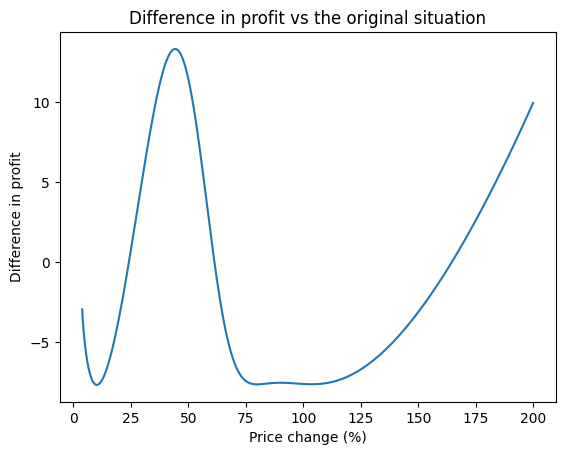

In [4]:
plt.plot(price_values_change*100, optimal_profit - originalProfit)
plt.xlabel('Price change (%)')
plt.ylabel('Difference in profit')
plt.title('Difference in profit vs the original situation')
plt.show()

def profitChange(price_change):
    current_price = (1+price_change) * price
    current_priceLow = (1+price_change) * priceLow
    demand = meanDemand * (1 - (priceDemandFunc(price_change * 100)))
    Q_star = calculateOptimalOrderQuantity( current_price, current_priceLow, newCost, newShippingCost, stdevDemand, demand)
    profit = calculateOptimalProfit(current_price, current_priceLow, newCost, newShippingCost, Q_star, demand, stdevDemand)
    return profit - originalProfit



Because we are dealing with a function that is not concave and we want the smallest possible price increase so we can keep out profit level the same, we will need to set a boundry for the optmization.

Set the initial guess to a value observed in the graph.

In [5]:
# set to observation
profitInitialGuess = 0.25
requiredProfitChange = fsolve(profitChange, profitInitialGuess)

print("The required cost change for a {0}% price hike will be {1}%.".format((cost_increase - 1) * 100, round(float(requiredProfitChange),5) * 100))

The required cost change for a 25.0% price hike will be 24.099%.
